<center><h1> DGA Detection Model 

<img src="Blue Minimalist Cyber Security .jpg"  width="1000"/>

## Introduction 
<h3>The project aims to develop a machine learning model to detect Domain Generation Algorithms (DGAs) from a dataset of 20,200 domain entries. The model uses advanced machine learning techniques and feature engineering to enhance detection and mitigation of DGAs, thereby strengthening network security against evolving cyber threats.</h3>

## Data set 

In [99]:
import pandas as pd

In [100]:
data = pd.read_csv('dataset_DGA.csv')
# Rename the columns
data.columns = ['Label', 'DGA_Type', 'Domain']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     20200 non-null  object
 1   DGA_Type  20200 non-null  object
 2   Domain    20200 non-null  object
dtypes: object(3)
memory usage: 473.6+ KB


In [101]:
label_counts = data['Label'].value_counts()
dga_type_counts = data['DGA_Type'].value_counts()
domain_counts = data['Domain'].value_counts()

print("Label counts:")
print(label_counts)

print("\nDGA Type counts:")
print(dga_type_counts)

print("\nDomain counts:")
print(domain_counts)


Label counts:
dga      10144
legit    10056
Name: Label, dtype: int64

DGA Type counts:
alexa           10056
emotet            451
fobber            447
tinba             432
simda             427
pykspa            427
kraken            425
padcrypt          424
matsnu            423
symmi             421
pushdo            420
suppobox          418
ramdo             411
ramnit            407
cryptolocker      404
murofet           398
gozi              397
vawtrak           395
corebot           390
necurs            388
ranbyus           381
nymaim            378
dircrypt          372
conficker         372
qadars            370
rovnix            366
Name: DGA_Type, dtype: int64

Domain counts:
plasticbags.sa.com        1
nude-virgin.com           1
designyoursite.co         1
equityatthetable.com      1
dmhx.sg                   1
                         ..
com-ciao.com              1
opendi.co                 1
kummyaiq.biz              1
zoyathinks.blogspot.ca    1
aeiiociowskusyq

In [102]:
data['DGA_Type'].unique()

array(['alexa', 'ranbyus', 'symmi', 'emotet', 'dircrypt', 'matsnu',
       'simda', 'fobber', 'pushdo', 'qadars', 'kraken', 'ramnit',
       'nymaim', 'pykspa', 'tinba', 'murofet', 'cryptolocker', 'ramdo',
       'vawtrak', 'conficker', 'padcrypt', 'rovnix', 'suppobox', 'necurs',
       'corebot', 'gozi'], dtype=object)

## Data preprossessing 
* Num of characters (num_char):  the length of each domain name.

* Unique character rate (Unique characters ratio): Calculates the ratio of unique characters to total characters in each domain.

* Number of vowels (Vowels) and consonants (Consonant): Counts the number of vowels and consonants in each domain name .

* Percentage of numeric characters (percentage of numeric characters): Calculates the percentage of numeric characters in each domain name .

* Entropy (Entropy): Calculates the entropy of each domain name and adds it as a new column. Entropy is a measure of randomness or unpredictability.

* N-grams and similarity (3_grams and 4_grams): Calculates the Jaccard similarity between each domain name and a list of 3-grams (d_3gram) and 4-grams (d_4gram) of legitimate domain names.

* Number of dots (ndots): Counts the number of dots in each domain name.

* Number of consecutive vowels (Number of consecutive vowels): Calculates the number of consecutive vowels in each domain name .

* Longest sequence of consonants (Longest consonant sequence): Finds the longest sequence of consecutive consonants in each domain name.

* Label encoding: Encodes the 'Label' and 'DGA_Type' columns using LabelEncoder from scikit-learn.


#### The importance of each preprocessing step for detecting Domain Name Angular Species (DGAs) can be summarized as follows:

1. Length of domain name: The length of the domain name can provide insights into its structure and complexity.
2. Unique character rate: The ratio of unique characters to total characters can help identify patterns or anomalies in domain names.
3. Number of vowels and consonants: The count of vowels and consonants can indicate linguistic properties.
4. Percentage of numeric characters: The percentage of numeric characters can indicate random or pseudo-random patterns.
5. Entropy: Entropy measures the randomness of data, helping to identify domains with unusual or suspicious patterns.
6. N-grams and similarity: Calculating Jaccard similarity between domain names and legitimate domain names can help identify domains with similar patterns.

In [103]:
import pandas as pd
import math
import re
from collections import Counter
from nltk.util import ngrams
from sklearn.preprocessing import LabelEncoder

def data_preprocessing(data):
    # Num of characters 
    data["num_char"] = data["Domain"].apply(len)
    
    # Unique character rate
    def calculate_unique_characters_ratio(domain):
        return len(set(domain)) / len(domain)
    data["Unique characters ratio"] = data["Domain"].apply(calculate_unique_characters_ratio)
    
    # Number of consonant
    data['Vowels'] = data['Domain'].str.lower().str.count(r'[aeiou]')
    data['Consonant'] = data.Domain.str.lower().str.count(r'[a-z]') - data['Vowels']
    
    # Percentage of numeric characters
    def percentage_of_numerical_chars(data):
        alpha = []
        numeric = []
        for i in data["Domain"]:
            c_alpha = sum(1 for j in i if not j.isdigit())
            c_digit = sum(1 for j in i if j.isdigit())
            alpha.append(c_alpha)
            numeric.append(c_digit)
        data["percentage of numeric characters"] = [a / (a + n) for a, n in zip(alpha, numeric)]
        return data
    
    data = percentage_of_numerical_chars(data)
    
    # Entropy
    def entropy(s):
        p, lns = Counter(s), float(len(s))
        return -sum(count / lns * math.log(count / lns, 2) for count in p.values())
    
    data['Entropy'] = data['Domain'].apply(lambda x: entropy(x))
    
    # N-grams and similarity
    def create_ngrams(data_list, n):
        n_grams = []
        for i in data_list:
            l1 = list(ngrams(str(i), n))
            for gram in l1:
                n_grams.append("".join(gram))
        return n_grams
    
    def jaccard_similarity(str1, d, n):
        str1_ngrams = create_ngrams([str1], n)
        intersection = len(set(str1_ngrams).intersection(set(d)))
        union = len(set(str1_ngrams).union(set(d)))
        return float(intersection) / union
    
    list1 = data.loc[data["Label"] == "legit", "Domain"].tolist()
    d_3gram = create_ngrams(list1, 3)
    d_4gram = create_ngrams(list1, 4)
    
    data["3_grams"] = data["Domain"].apply(lambda x: jaccard_similarity(x, d_3gram, 3))
    data["4_grams"] = data["Domain"].apply(lambda x: jaccard_similarity(x, d_4gram, 4))
    
    # Number of dots
    data['ndots'] = data['Domain'].str.count("\.")
    
    # Number of consecutive vowels
    def count_vowels(word):
        return sum(1 for i in range(len(word) - 1) if word[i] in 'aeiou' and word[i + 1] in 'aeiou')
    
    data["Number of consecutive vowels"] = data["Domain"].apply(count_vowels)
    
    # Longest sequence of consonants
    def find_consonants(string):
        q = re.findall(r'[^aeiou]+', string)
        return len(max(q, key=len)) if q else 0
    
    data["Longest consonant sequence"] = data["Domain"].apply(find_consonants)
    
    # Label encoding
    label_encoder = LabelEncoder()
    data["Label"] = label_encoder.fit_transform(data["Label"])
    if 'DGA_Type' in data.columns:
        data['DGA_Type'] = label_encoder.fit_transform(data['DGA_Type'])
    
    return data


In [104]:
data = data_preprocessing(data)

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Label                             20200 non-null  int32  
 1   DGA_Type                          20200 non-null  int32  
 2   Domain                            20200 non-null  object 
 3   num_char                          20200 non-null  int64  
 4   Unique characters ratio           20200 non-null  float64
 5   Vowels                            20200 non-null  int64  
 6   Consonant                         20200 non-null  int64  
 7   percentage of numeric characters  20200 non-null  float64
 8   Entropy                           20200 non-null  float64
 9   3_grams                           20200 non-null  float64
 10  4_grams                           20200 non-null  float64
 11  ndots                             20200 non-null  int64  
 12  Numb

In [106]:
# Remove duplicates
print(data.duplicated().sum())


0


In [107]:
# Get unique DGA types and their counts
dga_type_counts = data['DGA_Type'].value_counts()
dga_type_counts

0     10056
5       451
6       447
24      432
21      427
15      427
8       425
13      424
9       423
23      421
14      420
22      418
17      411
18      407
3       404
10      398
7       397
25      395
2       390
11      388
19      381
12      378
4       372
1       372
16      370
20      366
Name: DGA_Type, dtype: int64

## Buliding Model
 - LazyPredict is a Python library that simplifies the process of building and comparing machine learning models without extensive code or parameter tuning. It automatically fits regression or classification models to data and provides a summary of their performance. LazyPredict is easy to use, supports various metrics, handles regression and classification tasks, and works with pandas DataFrames, simplifying data preparation.

In [108]:
pip install lazypredict


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [109]:
from sklearn.model_selection import train_test_split
X = data.drop(['Label', 'Domain','DGA_Type'], axis=1)
y = data['Label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [110]:
# Lazy Predict
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:39<00:00,  1.36s/it]

[LightGBM] [Info] Number of positive: 8004, number of negative: 8156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 16160, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495297 -> initscore=-0.018812
[LightGBM] [Info] Start training from score -0.018812
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
CalibratedClassifierCV             1.00               1.00     1.00      1.00   
LinearSVC                          1.00               1.00     1.00      1.00   
Perceptron                         0.99               0.99     0.99      0.99   
SGDClassifier                      0.99

## Random Forest Classifier

In [111]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model on the test data
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)


Best Parameters: {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 25}
Accuracy: 0.9522277227722772


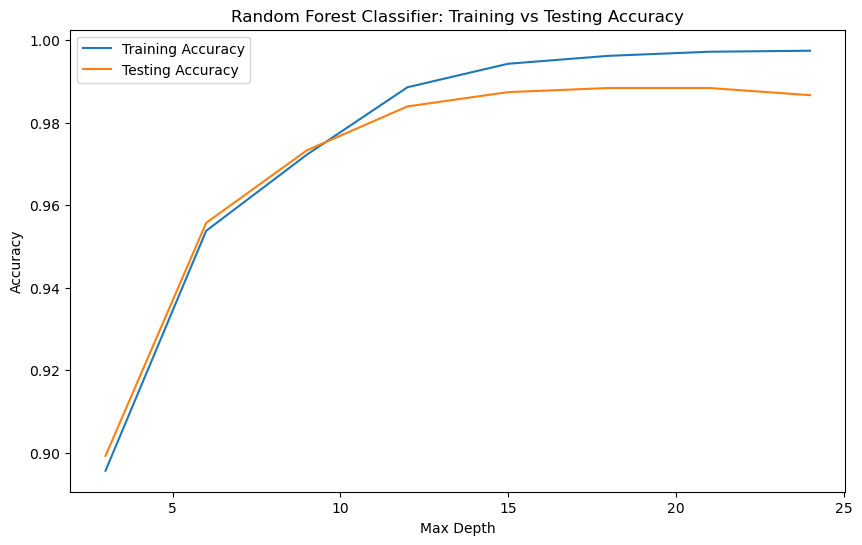

In [112]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score


train_accuracy = []
test_accuracy = []
depths = [3, 6, 9, 12, 15, 18, 21, 24]  # Varying max_depth

for depth in depths:
    # Create and fit the model
    rf_classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = rf_classifier.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))

    # Calculate testing accuracy
    y_test_pred = rf_classifier.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracy, label='Training Accuracy')
plt.plot(depths, test_accuracy, label='Testing Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier: Training vs Testing Accuracy')
plt.legend()
plt.show()


## SVM Classifier

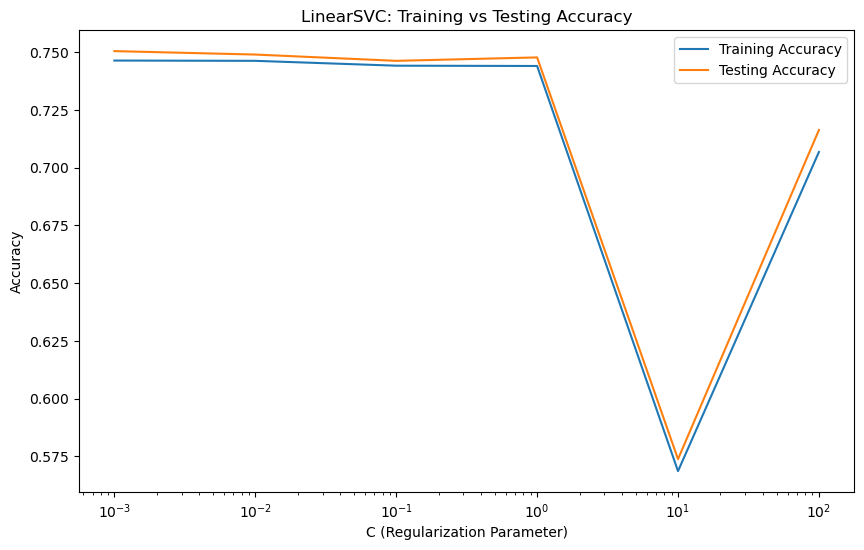

Best C value: 0.001
Final Testing Accuracy: 0.7504950495049505


In [113]:
from sklearn.svm import LinearSVC

train_accuracy = []
test_accuracy = []
#The regularization parameter C balances training and testing errors, with smaller values preventing
#overfitting and larger values reducing it. Iterating over different values and evaluating model performance helps find the optimal C value for testing accuracy.
C_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Varying the regularization parameter C

for C in C_values:
    # Create and fit the model
    svc_classifier = LinearSVC(C=C, random_state=42, max_iter=10000)
    svc_classifier.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = svc_classifier.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))

    # Calculate testing accuracy
    y_test_pred = svc_classifier.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracy, label='Training Accuracy')
plt.plot(C_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('LinearSVC: Training vs Testing Accuracy')
plt.legend()
plt.xscale('log')  # Using a logarithmic scale for better visualization if C_values are wide-ranging
plt.show()

# Get the best C value
best_C = C_values[np.argmax(test_accuracy)]
print(f"Best C value: {best_C}")

# Train the final model with the best C value
final_svc_classifier = LinearSVC(C=best_C, random_state=42, max_iter=10000)
final_svc_classifier.fit(X_train, y_train)

# Evaluate the final model
final_accuracy = accuracy_score(y_test, final_svc_classifier.predict(X_test))
print(f"Final Testing Accuracy: {final_accuracy}")


## LightGBM Classifier

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8004, number of negative: 8156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 16160, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495297 -> initscore=-0.018812
[LightGBM] [Info] Start training from score -0.018812
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8004, number of negative: 8156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 16160, number of used fea

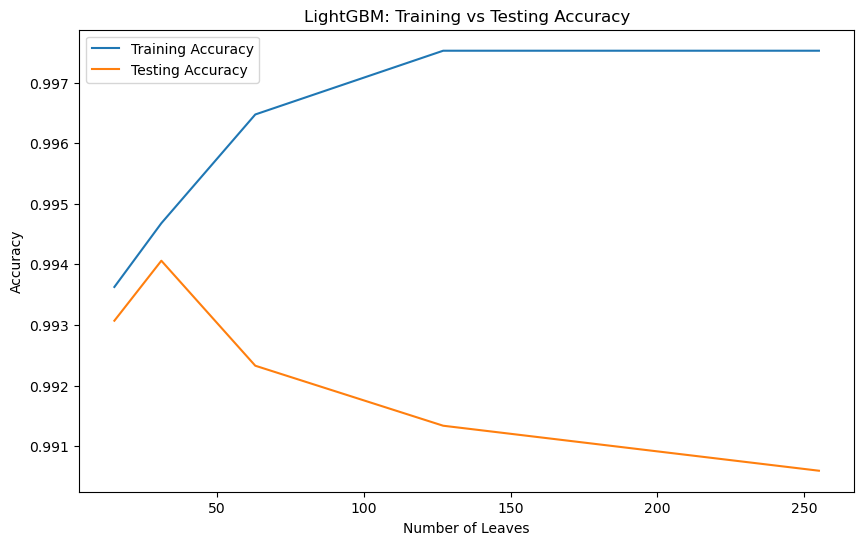

Best Number of Leaves: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8004, number of negative: 8156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 16160, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495297 -> initscore=-0.018812
[LightGBM] [Info] Start training from score -0.018812
Final Testing Accuracy: 0.994059405940594


In [114]:
from lightgbm import LGBMClassifier

train_accuracy = []
test_accuracy = []
num_leaves_values = [15, 31, 63, 127, 255]  # Varying the number of leaves in a tree

for num_leaves in num_leaves_values:
    # Create and fit the model
    lgbm_classifier = LGBMClassifier(num_leaves=num_leaves, random_state=42)
    lgbm_classifier.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = lgbm_classifier.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))

    # Calculate testing accuracy
    y_test_pred = lgbm_classifier.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_leaves_values, train_accuracy, label='Training Accuracy')
plt.plot(num_leaves_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Leaves')
plt.ylabel('Accuracy')
plt.title('LightGBM: Training vs Testing Accuracy')
plt.legend()
plt.show()

# Get the best number of leaves
best_num_leaves = num_leaves_values[np.argmax(test_accuracy)]
print(f"Best Number of Leaves: {best_num_leaves}")

# Train the final model with the best number of leaves
final_lgbm_classifier = LGBMClassifier(num_leaves=best_num_leaves, random_state=42)
final_lgbm_classifier.fit(X_train, y_train)

# Evaluate the final model
final_accuracy = accuracy_score(y_test, final_lgbm_classifier.predict(X_test))
print(f"Final Testing Accuracy: {final_accuracy}")


## Logistic Regression

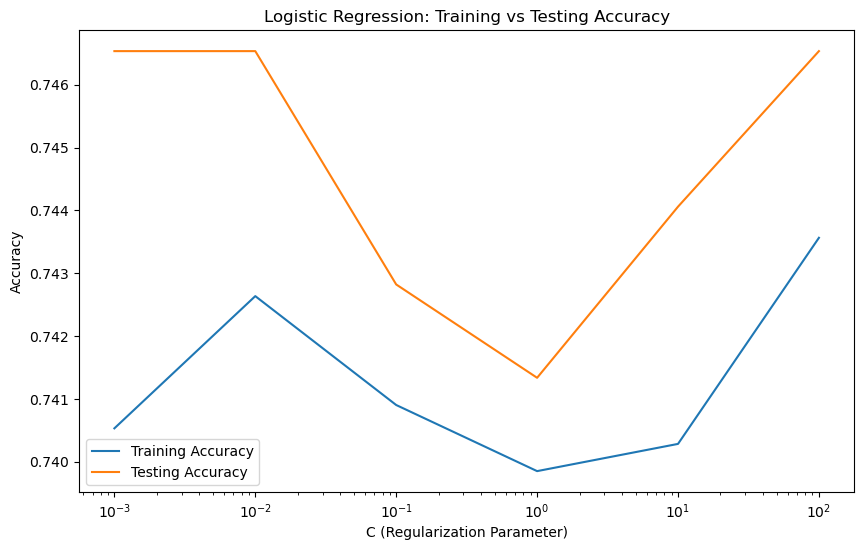

Best C value: 0.001
Final Testing Accuracy: 0.7465346534653465


In [115]:
from sklearn.linear_model import LogisticRegression

train_accuracy = []
test_accuracy = []
C_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Varying the regularization parameter C

for C in C_values:
    # Create and fit the model
    log_reg = LogisticRegression(C=C, random_state=42, max_iter=10000)
    log_reg.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = log_reg.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred))

    # Calculate testing accuracy
    y_test_pred = log_reg.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracy, label='Training Accuracy')
plt.plot(C_values, test_accuracy, label='Testing Accuracy')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression: Training vs Testing Accuracy')
plt.legend()
plt.xscale('log')  # Using a logarithmic scale for better visualization if C_values are wide-ranging
plt.show()

# Get the best C value
best_C = C_values[np.argmax(test_accuracy)]
print(f"Best C value: {best_C}")

# Train the final model with the best C value
final_log_reg = LogisticRegression(C=best_C, random_state=42, max_iter=10000)
final_log_reg.fit(X_train, y_train)

# Evaluate the final model
final_accuracy = accuracy_score(y_test, final_log_reg.predict(X_test))
print(f"Final Testing Accuracy: {final_accuracy}")


### besed on the result the random forest is the best model for DGA detection with an acuracy of 0.95

## Validation

In [116]:
# Validation data
validation =pd.read_csv('dga_domains_sample.csv')
validation.columns = ['Label', 'DGA_Type', 'Domain']

In [117]:
copy_validation = validation.copy()

In [118]:
validation = data_preprocessing(validation)

In [119]:
validation = validation.drop(columns=['Label', 'DGA_Type', 'Domain'])

In [120]:
validation['prediction'] = best_model.predict(validation)

In [121]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   num_char                          9999 non-null   int64  
 1   Unique characters ratio           9999 non-null   float64
 2   Vowels                            9999 non-null   int64  
 3   Consonant                         9999 non-null   int64  
 4   percentage of numeric characters  9999 non-null   float64
 5   Entropy                           9999 non-null   float64
 6   3_grams                           9999 non-null   float64
 7   4_grams                           9999 non-null   float64
 8   ndots                             9999 non-null   int64  
 9   Number of consecutive vowels      9999 non-null   int64  
 10  Longest consonant sequence        9999 non-null   int64  
 11  prediction                        9999 non-null   int32  
dtypes: flo

In [122]:
validation['prediction']

0       0
1       1
2       1
3       1
4       0
       ..
9994    0
9995    0
9996    0
9997    1
9998    0
Name: prediction, Length: 9999, dtype: int32

In [123]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

copy_validation['Label'] = label_encoder.fit_transform(copy_validation['Label'])
copy_validation.head()

,Label,DGA_Type,Domain
0,0,corebot,cvyh1po636avyrsxebwbkn7.ddns.net
1,1,alexa,plasticbags.sa.com
2,1,alexa,mzltrack.com
3,1,alexa,miss-slim.ru
4,0,ranbyus,txumyqrubwutbb.cc


In [124]:
copy_validation['prediction']= validation['prediction']

In [125]:
copy_validation.head()

,Label,DGA_Type,Domain,prediction
0,0,corebot,cvyh1po636avyrsxebwbkn7.ddns.net,0
1,1,alexa,plasticbags.sa.com,1
2,1,alexa,mzltrack.com,1
3,1,alexa,miss-slim.ru,1
4,0,ranbyus,txumyqrubwutbb.cc,0


In [126]:
# Compare the predicted values with the actual labels in the copy of the validation data
correct_predictions = (copy_validation['prediction'] == copy_validation['Label']).sum()
total_predictions = len(copy_validation)

# Calculate the number of incorrect predictions
incorrect_predictions = total_predictions - correct_predictions

# Calculate the ratio of correct predictions
accuracy_ratio = correct_predictions / total_predictions

print(f"Number of correct predictions: {correct_predictions}")
print(f"Number of incorrect predictions: {incorrect_predictions}")
print(f"Total number of predictions: {total_predictions}")
print(f"Accuracy ratio: {accuracy_ratio:.2f}")


Number of correct predictions: 9163
Number of incorrect predictions: 836
Total number of predictions: 9999
Accuracy ratio: 0.92


In [127]:
# save the model 
import pickle 
DGA_model = 'DGA_model.pkl'
pickle.dump(best_model,open(DGA_model,'wb'))